# Searching for objects in mock images from the ArcsFinding Challenge

The challenge is proposed by the Bologna group, http://metcalf1.bo.astro.it/blf-portal/gg_challenge.html .

I have here, now, a small set of images to play with. And I will choose one to scratch the problem.

Our final goal in this challenge is to say whether a given image contains or not (simulated) gravitationally lensed objects. From the image processing point-of-view, we have to segment and extract a set of properties of the image' contents, and then use such properties to classify whether we are dealing with a lens (1) or not (0).

In [1]:
ls data

imageEUC_VIS-100002.fits  imageEUC_VIS-100013.fits  imageEUC_VIS-101843.fits
imageEUC_VIS-100003.fits  imageEUC_VIS-100014.fits  imageEUC_VIS-101846.fits
imageEUC_VIS-100010.fits  imageEUC_VIS-100019.fits  imageEUC_VIS-104135.fits


In [2]:
# filename = 'data/imageEUC_VIS-100003.fits'
filename = 'data/imageEUC_VIS-100003.fits'

Load some libraries...

In [3]:
import astropy
import skimage
import pandas
import numpy
import booq

np = numpy

pandas.set_option('display.max_columns',10)
pandas.set_option('display.width',100)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
from astropy.io import fits
img = fits.open(filename)[0].data
del filename

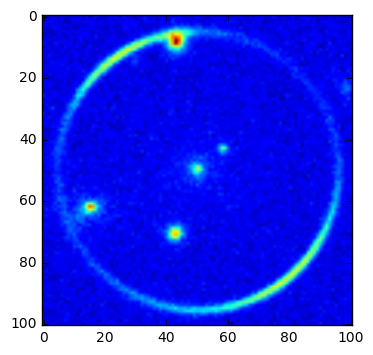

In [6]:
plt.imshow(img)#,cmap='Blues_r')

### Intensity distribution

In [7]:
def imhist(img,bins=100,vmarks=[],log=False,xlabel='X',ylabel='#', ax=None):
    """
    Plot histogram from image array
    #TODO This function should not remain here.
    
    Output:
     - plt  : pyplot object. plt.show() will give you the histogram.
    
    """
    def simple(hist,bins,vmarks=[],log=False,xlabel='X',ylabel='#', ax=None):
        """
        Plot histogram with vertical line marks

        Output:
         - plt  : pyplot object. plt.show() will give you the histogram.

        """
        from matplotlib import pyplot as plt
        if ax is None:
            fig,ax = plt.subplots()
        else:
            ax = plt
        width = 0.7*(bins[1]-bins[0])
        centers = (bins[:-1]+bins[1:])/2.
        ax.grid(True)
        ax.bar(centers, hist, width=width, align='center', color='g', log=log, alpha=0.9)
        try:
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
        except:
            ax.xlabel(xlabel)
            ax.ylabel(ylabel)

            

        ymax = hist.max()*1.01
        ymin = -ymax/50.

        for i,iv in enumerate(vmarks):
            ymaxn = ymax + i%2*(ymin*2)
            ax.vlines(iv,ymin,ymaxn,color='r')
            ax.text(iv,ymaxn,"%.1f"%(iv))

        return ax
    
    
    hist,bins = np.histogram(img.flatten(),bins=bins,normed=True)
    
    return simple(hist,bins,vmarks,log,xlabel,ylabel,ax)

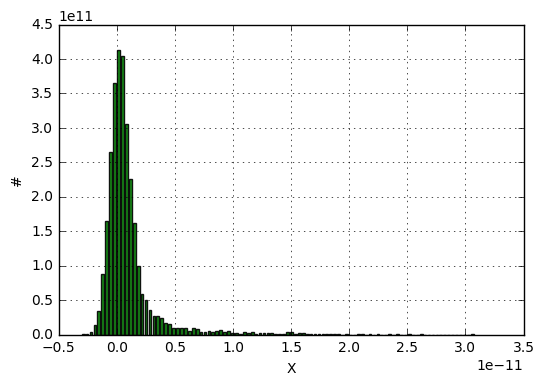

In [8]:
_ = imhist(img)

In [9]:
def normalize(img,unit=1):
    """
    Normalize 'img' to 'unit'
    """
    
    return unit * (img - img.min())/(img.max() - img.min())

img = normalize(img)

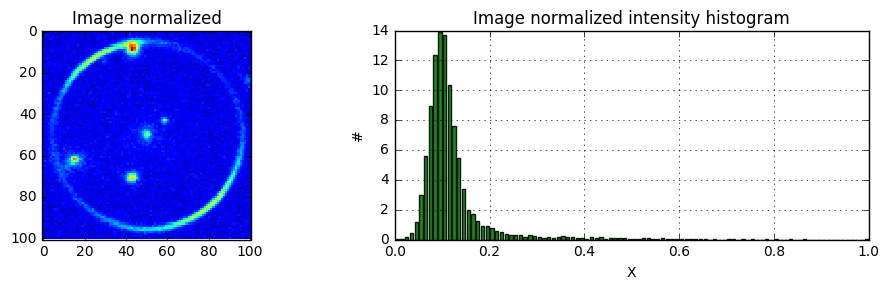

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3), sharex=False, sharey=False,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(img, interpolation='nearest')
ax[0].set_title('Image normalized')
_ = imhist(img,ax=ax[1])
ax[1].set_title('Image normalized intensity histogram')

fig.tight_layout()
plt.show()

## Pre-processing

### Entropy

In [11]:
from skimage.morphology import disk
from skimage.filters.rank import entropy

img_entr = entropy(img,disk(4))
# plt.imshow(img_entr)

/home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [12]:
# img_entr = equal(img_entr)

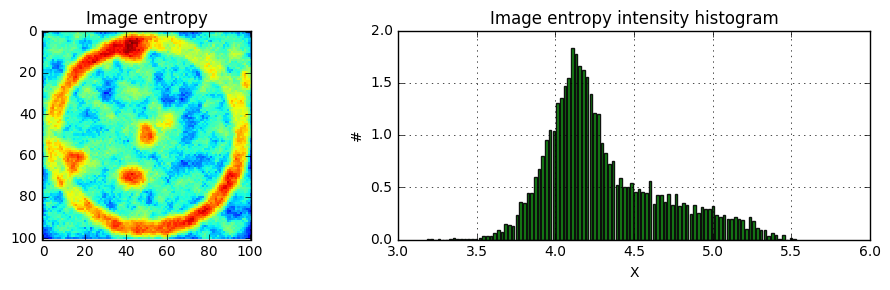

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3), sharex=False, sharey=False,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(img_entr, interpolation='nearest')
ax[0].set_title('Image entropy')
_ = imhist(img_entr,ax=ax[1])
ax[1].set_title('Image entropy intensity histogram')

fig.tight_layout()
plt.show()

### Smoothing

In [14]:
def gaussian(img, sigma=[3,3]):
    """
    Simple gaussian filter
    
    Input:
     - img <ndarray>
     - sigma <[int,int]> : sigma window
    
    Output:
     - <ndarray>
    
    ---
    """
    import scipy.ndimage as ndi
    return ndi.gaussian_filter(img,sigma);

img_smooth = gaussian(img,[2,2])

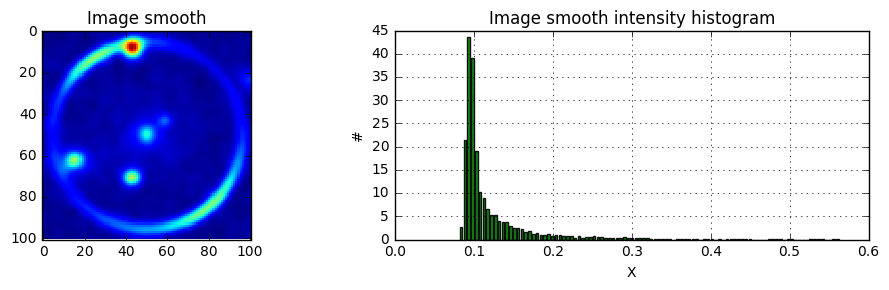

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3), sharex=False, sharey=False,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(img_smooth, interpolation='nearest')
ax[0].set_title('Image smooth')
_ = imhist(img_smooth,ax=ax[1])
ax[1].set_title('Image smooth intensity histogram')

fig.tight_layout()
plt.show()

In [16]:
# Thresholding
def histmax(img):
    """
    Maximum histogram value for threshold estimation
    """
    np = numpy
    
    nbins=1000
    imhist,bins = np.histogram(img.flatten(),nbins,normed=True);

    return bins[np.argmax(imhist)] + np.std(img)

# --

def riddler_calvard(img):
    """
    Riddler-Calvard method for image thrashold (fg|bg) estimation
    """
    import mahotas
    
    return mahotas.thresholding.rc(img)

# --

def otsu(img):
    """
    Otsu method for image thrashold (fg|bg) estimation
    """
    import mahotas
    
    return mahotas.thresholding.otsu(img)

def float2uint(img):
    """
    Normalize and truncate 'img' values to uint8 scale [0:255]
    """
    np = numpy;
    
    img = normalize(img) * 255.
    u_img = img.astype(np.uint8)
    
    return u_img

In [17]:
_img = img
th_mx = histmax(_img[np.where(_img)])
img_uint8 = float2uint(_img)
# th_rc = float(riddler_calvard(img_uint8) - img_uint8.min())/(img_uint8.max()-img_uint8.min())
# th_ot = float(otsu(img_uint8) - img_uint8.min())/(img_uint8.max()-img_uint8.min())
# print ' Histmax: {}\n R.Calvard: {}\n Otsu: {}'.format(th_mx,th_rc,th_ot)
# th_mean = (th_mx*0.7+th_rc*0.15+th_ot*0.15)
# print 'Mean: {}'.format(th_mean)

### Finding contours

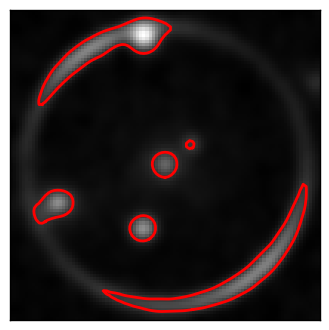

In [18]:
from skimage import measure
contours = measure.find_contours(img_smooth,th_mx)

fig, ax = plt.subplots()
ax.imshow(img_smooth, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Finding local maxima

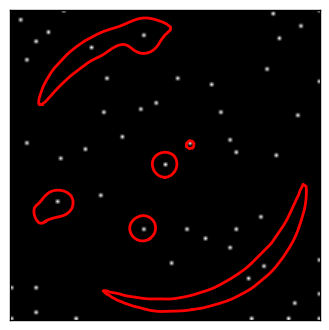

In [19]:
from skimage.feature import peak_local_max
local_maxi = peak_local_max(img_smooth, min_distance=2, exclude_border=False, indices=False)

fig, ax = plt.subplots()
ax.imshow(local_maxi, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [20]:
def create_mask(contours,img_shape):
    def define_regions(contours):
        '''
        Return a list of regions (~matplotlib.path.Path), for each entry in 'country_map'

        'country_map' is expected to provide columns 'lons' and 'lats',
        providing lists of coordinates defining the respective country
        as polygon(s). If 'country_map' has multiple lines, multiple
        "Paths" will be created (for each line/polygon).
        '''
        from matplotlib.path import Path
        import numpy as np
        regions_path = []
        for n, contour in enumerate(contours):
            regions_path.append( Path( contour ) )
        return regions_path

    # Create vertex coordinates for each grid cell...
    # (<0,0> is at the top left of the grid in this system)
    ny,nx = img_shape
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x, y = x.flatten(), y.flatten()

    grid = np.vstack((y,x)).T

    mask = np.zeros(img_shape).astype(bool)
    paths = define_regions(contours)
    for path in paths:
        _mask = path.contains_points(grid)
        mask = mask + _mask.reshape((ny,nx))
    return mask

mask = create_mask(contours,img_smooth.shape)

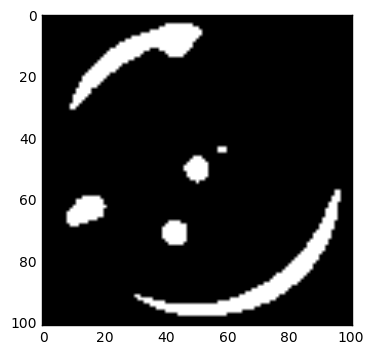

In [21]:
plt.imshow(mask, cmap='gray')

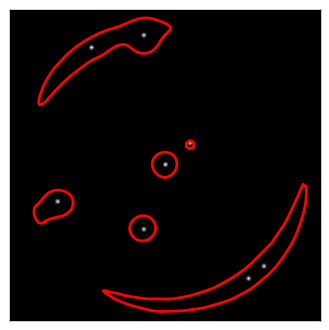

In [22]:
from skimage.feature import peak_local_max
local_maxi = peak_local_max(img_smooth*mask, min_distance=2, exclude_border=False, indices=False)

fig, ax = plt.subplots()
ax.imshow(local_maxi, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [23]:
def region_growing(img,x,y,thresh):
    """
    Segment using a Region Growing algorithm
    
    Input:
     - img  ndarray : Image array (ndim=2)
     - x        int : Seed x position
     - y        int : Seed y position
     - thresh float : Threshold value for limiting the grow
    
    Output:
     - region  : Region grown around given 'x,y'
    
    ---
    """
    from scipy import ndimage as ndi
    
    x_o = x
    y_o = y
    flag = True

#     logging.debug("RG seed: X(%d) Y(%d)",x_o,y_o)
#     logging.debug("Threshold: %.2f",thresh)

    # Initialize region with the seed point
    region = np.zeros(img.shape,dtype=np.bool)
    reg_old = (region==flag)

#     logging.debug("Image seed point value: %.2f",img[y_o,x_o])
    if (img[y_o,x_o] < thresh): return region
    
    region[y_o,x_o] = flag
    reg_cur = (region==flag)

    # For future (loop) morphological operations...
    strct_elem = ndi.generate_binary_structure(2,2)

    # While region stills changes (grow), do...
    while not np.all(region == reg_old):
        
        reg_old = region.copy()

        # Define pixel neighbours
        tmp = ndi.binary_dilation(region,strct_elem, 1)
        neigbors = tmp - region
        inds = np.where(neigbors)

        # Check for the new neighbors; do they fullfil requirements?
        #region[np.where(region[inds]>=thresh)] = flag
        for y_i,x_i in zip(*inds):
            if (img[y_i,x_i] >= thresh):
                region[y_i,x_i] = flag

    return region

/home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/ipykernel/__main__.py:45: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


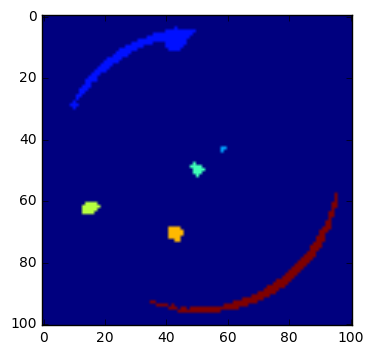

In [24]:
local_maxi = peak_local_max(img_smooth*mask, min_distance=2, exclude_border=False, indices=True)

fig, ax = plt.subplots()
img_reg = np.zeros(img.shape,dtype=int)
for n,local_max in enumerate(local_maxi):
    xy = local_maxi[n]
    y,x = xy
    reg = region_growing(img,x,y,th_mx+0.1)

    _img = reg.astype(int) * n
    _idx = np.where(reg)
    img_reg[_idx] = _img[_idx]
    
_ = ax.imshow(img_reg)

In [25]:
def equal(img,nbins=1000,savefig=True,figname='hist_equal.png'):
    """
    Equalizes given image histogram
    
    Input:
     - img ndarray : Image array
     - nbins int : Number of bins to use for equalization
    
    Output:
     - img_eq  ndarray : Image array equalized
    
    ---
    """
    
    imhist,bins = np.histogram(img.flatten(),nbins,normed=True)
    cdf = np.cumsum(imhist)
    cdf = cdf/cdf[-1]
    imgterp = np.interp(img.flatten(),bins[:-1],cdf)
    img_eq = imgterp.reshape(img.shape)
    
    return img_eq;

img_mask = img*mask
img_mask = equal(img_mask)
img_mask_smooth = gaussian(img_mask,[1,1])

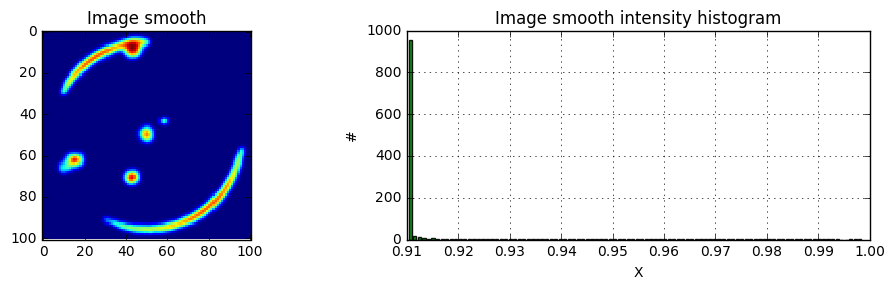

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3), sharex=False, sharey=False,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(img_mask_smooth, interpolation='nearest')
ax[0].set_title('Image smooth')
_ = imhist(img_mask_smooth,ax=ax[1])
ax[1].set_title('Image smooth intensity histogram')

fig.tight_layout()
plt.show()

In [27]:
local_maxi = peak_local_max(img_mask_smooth, exclude_border=False, indices=False)

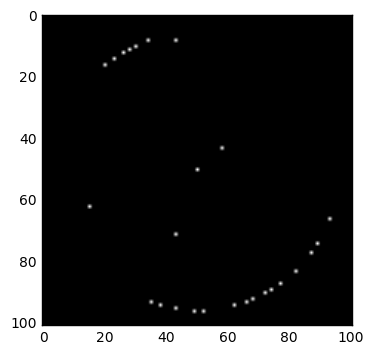

In [28]:
fig, ax = plt.subplots()
ax.imshow(local_maxi, cmap=plt.cm.gray)

In [29]:
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
# distance = ndi.distance_transform_edt(mask)
# local_maxi = peak_local_max(distance, indices=False,labels=mask)
markers = ndi.label(local_maxi)[0]
labels = watershed(-img_mask_smooth, markers, mask=mask)

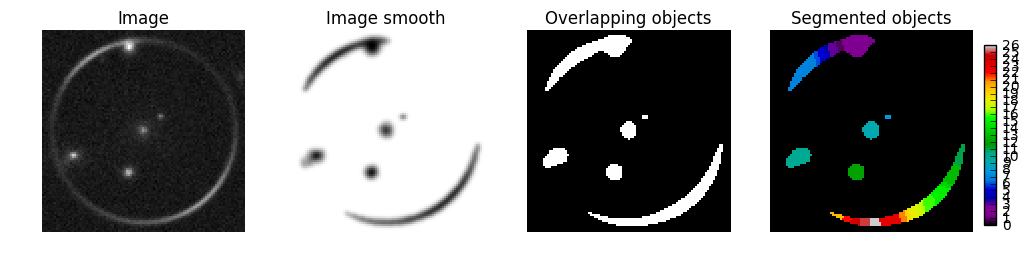

In [30]:
fig, axes = plt.subplots(ncols=4, figsize=(12, 3), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Image')

ax[1].imshow(-img_mask_smooth, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Image smooth')

ax[2].imshow(mask, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Overlapping objects')

im = ax[3].imshow(labels, cmap=plt.cm.spectral, interpolation='nearest')
ax[3].set_title('Segmented objects')

cax = fig.add_axes([0.91, 0.2, 0.01, 0.6])
vals = np.unique(labels)
fig.colorbar(im, cax=cax, ticks=vals)#,values=vals)

for a in ax:
    a.set_axis_off()

# fig.tight_layout()
plt.show()

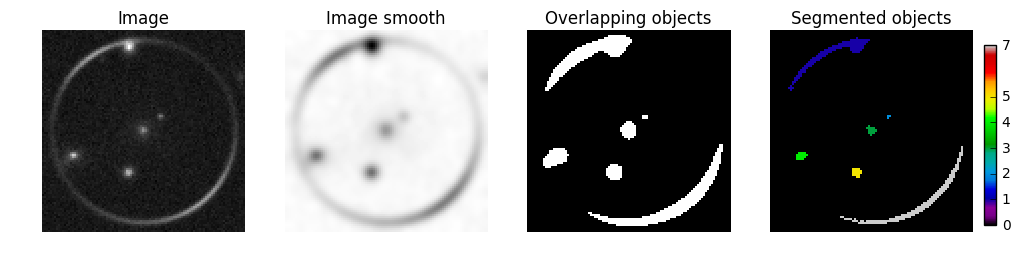

In [88]:
fig, axes = plt.subplots(ncols=4, figsize=(12, 3), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

_ = ax[0].imshow(img, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Image')

_ = ax[1].imshow(-img_smooth, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Image smooth')

_ = ax[2].imshow(mask, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Overlapping objects')

im = ax[3].imshow(img_reg, cmap=plt.cm.spectral, interpolation='nearest')
ax[3].set_title('Segmented objects')

cax = fig.add_axes([0.91, 0.2, 0.01, 0.6])
vals = np.unique(img_reg)
# fig.colorbar(im, cax=cax, values=vals, ticks=vals)
fig.colorbar(im, cax=cax, ticks=vals)

for a in ax:
    a.set_axis_off()

# fig.tight_layout()
plt.show()

## Regions properties

In [32]:
from skimage.measure import regionprops
reg_props = regionprops(img_reg,img_smooth)
# reg_props = regionprops(labels,img_smooth)


d_props = {}
l_props = []
d2_props = {}
l2_props = []
for props in reg_props:
    label = props.label
    vals = []
    vals2 = []
    for prop in props:
        val = props[prop]
        if np.isscalar(val):
            vals.append(val)
            l_props.append(prop)
        else:
#             if isinstance(val,np.ndarray):
#                 val = list(val.shape)
            vals2.append(val)
            l2_props.append(prop)
    d_props[label] = vals
    d2_props[label] = vals2

index = l2_props[:len(vals2)]
df2 = pandas.DataFrame(d2_props,index=index)#.transpose()

In [38]:
# 'df' contain morphological parameters from each identified object
index = l_props[:len(vals)]
df = pandas.DataFrame(d_props,index=index).transpose()

df

,area,convex_area,eccentricity,equivalent_diameter,euler_number,...,min_intensity,minor_axis_length,orientation,perimeter,solidity
1,150.0,361.0,0.983214,13.819766,1.0,...,0.182833,9.569537,0.482935,94.740115,0.415512
2,3.0,3.0,0.816497,1.954410,1.0,...,0.187410,1.333333,0.785398,3.414214,1.000000
3,13.0,14.0,0.645234,4.068429,1.0,...,0.234801,3.679465,-0.785398,11.899495,0.928571
4,19.0,19.0,0.758469,4.918491,1.0,...,0.260854,3.921671,0.321751,13.656854,1.000000
5,20.0,20.0,0.429969,5.046265,1.0,...,0.253053,4.806286,-0.724168,14.242641,1.000000
7,174.0,919.0,0.972249,14.884343,1.0,...,0.188094,17.543803,0.544413,140.604076,0.189336


In [34]:
print df2

                                                                             1  \
bbox                                                            (4, 9, 31, 50)   
centroid                                                (12.32, 30.6866666667)   
convex_image                 [[False, False, False, False, False, False, Fa...   
coords                       [[4, 43], [5, 40], [5, 41], [5, 42], [5, 43], ...   
filled_image                 [[False, False, False, False, False, False, Fa...   
image                        [[False, False, False, False, False, False, Fa...   
moments                      [[150.0, 1248.0, 16618.0, 282390.0], [3253.0, ...   
moments_central              [[150.0, 9.37916411203e-13, 6234.64, 40383.830...   
moments_hu                   [1.18430725926, 1.2276504533, 0.435783944152, ...   
moments_normalized           [[nan, nan, 0.277095111111, 0.146547819762], [...   
weighted_centroid                               (11.2990367488, 32.7931532351)   
weighted_moments

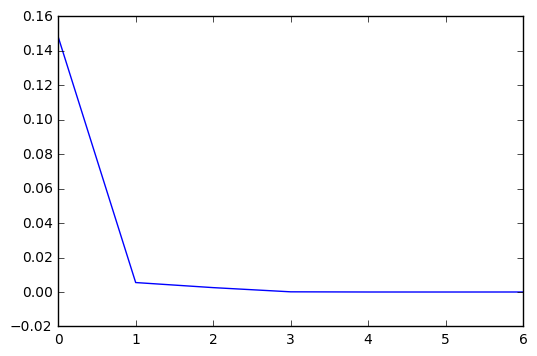

In [35]:
_y_ = np.asarray(df2[2].loc['moments_hu'])
_x_ = np.arange(len(_y_))
plt.plot(_x_,_y_)

### Erosion

What about eroding the labels/regions? Instead of a cluster of pixels, I want a point or a line representing the object(s).

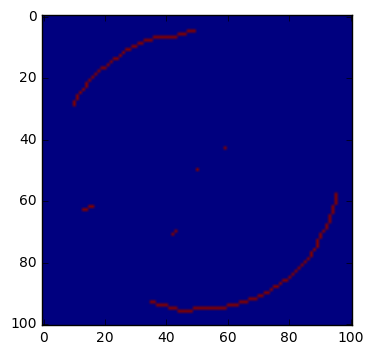

In [36]:
from skimage import morphology

_img = img_reg.copy()

lbls = list(np.unique(_img))
lbls.sort()
_ = lbls.pop(0)

img_erod = np.zeros(_img.shape,dtype=int)
for n in lbls:
    _mask = np.zeros(_img.shape,dtype=int)
    _mask[np.where(_img==n)] = 1
#     _mask = morphology.binary_erosion(_mask, morphology.disk(1))
#     _mask = morphology.medial_axis(_mask)
    _mask = morphology.skeletonize(_mask)
    img_erod += _mask

plt.imshow(img_erod)

## Homogenization of features

We notice that the number of extracted objects varies depending on the methods applied and obviously on the number of "real" objects in the image.
For the classification step I want to use a Machine Learning method.
To train a machine, we need a fixed size of properties describing such images, otherwise we will have to deal a variable number of machines or it would be the same as dealing with a sparse features vector.

The idea is to reduce the dimension of the data space whenever there is more than one object in the image.
One way of doing this is to proceed with some statistical measurements to each property accross the multiple (segmented) objects.
Consider, for example, the *ellipticity* of the segmented objects.
At this step, we can measure its *mean* and *variance* accross the objects; when only one object is found, *mean* is the value itself and *variance* is zero.

### Stats of stats

A way to work over a variable number of vectors -- i.e, features from each segmented object -- is by using statistical measurements of each feature (column) from the input vectors.

In [39]:
# Let's then take out some stats from 'df'
df.describe()

,area,convex_area,eccentricity,equivalent_diameter,euler_number,...,min_intensity,minor_axis_length,orientation,perimeter,solidity
count,6.000000,6.000000,6.000000,6.000000,6.0,...,6.000000,6.000000,6.000000,6.000000,6.000000
mean,63.166667,222.666667,0.767605,7.448617,1.0,...,0.217841,6.809016,0.104155,46.426233,0.755570
std,77.168431,368.338250,0.209673,5.471131,0.0,...,0.035817,5.915759,0.682080,57.193431,0.359285
min,3.000000,3.000000,0.429969,1.954410,1.0,...,0.182833,1.333333,-0.785398,3.414214,0.189336
25%,14.500000,15.250000,0.673543,4.280944,1.0,...,0.187581,3.740016,-0.462688,12.338835,0.543777
50%,19.500000,19.500000,0.787483,4.982378,1.0,...,0.211448,4.363978,0.402343,13.949747,0.964286
75%,117.500000,275.750000,0.933311,11.626391,1.0,...,0.248490,8.378724,0.529043,74.615747,1.000000
max,174.000000,919.000000,0.983214,14.884343,1.0,...,0.260854,17.543803,0.785398,140.604076,1.000000


In [40]:
import booq

In [41]:
help(booq)

Help on package booq:

NAME
    booq - This is an Astropy affiliated package.

FILE
    /home/chbrandt/fido/repos/booq/booq/__init__.py

PACKAGE CONTENTS
    _astropy_init
    catalogs (package)
    common (package)
    conftest
    coordinates (package)
    core (package)
    data (package)
    example_mod
    filters (package)
    image (package)
    io (package)
    pipelines (package)
    plot (package)
    role (package)
    table (package)
    tests (package)
    ucd (package)
    utils (package)

SUBMODULES
    log

DATA
    __githash__ = ''
    __version__ = ''

VERSION





In [42]:
from booq.table import ADataFrame

In [43]:
adf = ADataFrame(df)

In [44]:
adf

,area,convex_area,eccentricity,equivalent_diameter,euler_number,...,min_intensity,minor_axis_length,orientation,perimeter,solidity
1,150.0,361.0,0.983214,13.819766,1.0,...,0.182833,9.569537,0.482935,94.740115,0.415512
2,3.0,3.0,0.816497,1.954410,1.0,...,0.187410,1.333333,0.785398,3.414214,1.000000
3,13.0,14.0,0.645234,4.068429,1.0,...,0.234801,3.679465,-0.785398,11.899495,0.928571
4,19.0,19.0,0.758469,4.918491,1.0,...,0.260854,3.921671,0.321751,13.656854,1.000000
5,20.0,20.0,0.429969,5.046265,1.0,...,0.253053,4.806286,-0.724168,14.242641,1.000000
7,174.0,919.0,0.972249,14.884343,1.0,...,0.188094,17.543803,0.544413,140.604076,0.189336


In [45]:
adf.describe()

             area  convex_area  eccentricity  equivalent_diameter  euler_number    ...     \
count    6.000000     6.000000      6.000000             6.000000           6.0    ...      
mean    63.166667   222.666667      0.767605             7.448617           1.0    ...      
std     77.168431   368.338250      0.209673             5.471131           0.0    ...      
min      3.000000     3.000000      0.429969             1.954410           1.0    ...      
25%     14.500000    15.250000      0.673543             4.280944           1.0    ...      
50%     19.500000    19.500000      0.787483             4.982378           1.0    ...      
75%    117.500000   275.750000      0.933311            11.626391           1.0    ...      
max    174.000000   919.000000      0.983214            14.884343           1.0    ...      

       min_intensity  minor_axis_length  orientation   perimeter  solidity  
count       6.000000           6.000000     6.000000    6.000000  6.000000  
mean    

In [46]:
%qtconsole

In [48]:
import pandas

help(pandas.stats)

Help on package pandas.stats in pandas:

NAME
    pandas.stats

FILE
    /home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/pandas/stats/__init__.py

PACKAGE CONTENTS
    api
    common
    fama_macbeth
    interface
    math
    misc
    moments
    ols
    plm
    tests (package)
    var




Help on module pandas.stats.fama_macbeth in pandas.stats:

NAME
    pandas.stats.fama_macbeth

FILE
    /home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/pandas/stats/fama_macbeth.py

CLASSES
    pandas.core.base.StringMixin(__builtin__.object)
        FamaMacBeth
            MovingFamaMacBeth
    
    class FamaMacBeth(pandas.core.base.StringMixin)
     |  Method resolution order:
     |      FamaMacBeth
     |      pandas.core.base.StringMixin
     |      __builtin__.object
     |  
     |  Methods defined here:
     |  
     |  __init__(self, y, x, intercept=True, nw_lags=None, nw_lags_beta=None, entity_effects=False, time_effects=False, x_effects=None, cluster=None, dropped_dummies=None, verbose=False)
     |  
     |  __unicode__(self)
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |  
     |  mean_beta
     |  
     |  std_beta
     |  
     |  summary
     |  
     |  t_stat
     |